## Random Forest Classification

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

### Load and prepare the data

About the dataset

the dataset contains a collection of SMS messages. It was manually extracted from the Grumbletext Web site, this is a UK forum in which cell phone users make public claims about SMS spam messages, most of them without reporting the very spam message received.

Objective: build a random forest classification model that will be able to tell spam messages from ham messages

Goal: create a reliable and user-friendly tool that can accurtely classify a message as either "spam" or "ham"(not spam)

In [2]:
# Load the data
df = pd.read_csv(r"C:\Users\DELL\Desktop\ML\Datasets\spam\SMSSpamCollection", sep = "\t", header = None, names = ["Label", "Text"])

In [3]:
# inspect by displaying first few rows
df.head()

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
# get the total number of columns and rows
df.shape

(5572, 2)

In [5]:
# get an overview of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   5572 non-null   object
 1   Text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [6]:
# check for duplicates
df.duplicated().sum()

np.int64(403)

In [7]:
# drop duplicates
df = df.drop_duplicates()

### Data preprocessing

In [8]:
#seperate the dataset into independent and target variables
X = df["Text"]
y = df["Label"]

# encode the labels
y = y.map({"ham": 0, "spam": 1})

In [9]:
# check class imbalance
y.value_counts()

Label
0    4516
1     653
Name: count, dtype: int64

In [10]:
# data splitting into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4135,) (1034,) (4135,) (1034,)


In [11]:
X.shape

(5169,)

### Convert text to numeric format
TfidffVectorizer converts the texts into a large numerical matrix, each row representing each message and each column representing a unique word from the entire dataset's vocab.
It calculates a score for each word using Term Frequency(TF) that is, how often the word appears, and Inverse Document Frequency (IDF) that is, how rare the word is across all messages in the entire dataset. the score is the product of TF and IDF

### Handle class imbalance
using SMOTE TO synthesize new instances of the minority class
and including all in a pipeline to avoid data leakage

In [12]:
# vectorizer = TfidfVectorizer(stop_words = "english")

# X = vectorizer.fit_transform(X)

In [13]:
rf_pipeline = ImbPipeline([
("vectorizer", TfidfVectorizer(stop_words = "english")),
("sampler", SMOTE(random_state = 42)),
("classifier", RandomForestClassifier(random_state = 42))])

### Hyperparameter tuning and model training
Randomized search technique

unlike grid search that creates every possible combination of hyperparameters, Randomized search samples a fixed number (n_iter) of random combinations from the specified parameter distribution. it is faster and more efficient than its counterpart

In [14]:
# list of hyperparameters and their respective range of values (grid definition)
param_distributions = {
    "sampler__k_neighbors": [3, 5],
    "classifier__max_depth": [3, 5, 10, None],  
    "classifier__min_samples_split": [2, 5, 10],
    "classifier__min_samples_leaf": [1, 2, 4, 8],
    "classifier__n_estimators": [50, 100, 200] 
}

The model is trained and evaluated multiple times (cross validation) for a fixed number of combination of hyperparameters and the set of hyperparameters that results in the highest average-precision score is selected

In [15]:
random_search = RandomizedSearchCV(estimator = rf_pipeline, param_distributions = param_distributions, scoring = "average_precision", n_iter = 50, cv = StratifiedKFold(n_splits=3), n_jobs = -1, verbose = 2, random_state = 42)
print("Starting randomized search\n")
random_search.fit(X_train, y_train)
print("Randomized search complete\n")
print("best parameters are:\n", random_search.best_params_)
print("best score:", random_search.best_score_)

Starting randomized search

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Randomized search complete

best parameters are:
 {'sampler__k_neighbors': 3, 'classifier__n_estimators': 100, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': None}
best score: 0.9636773473463848


The final model trained using the best hyperparameters on the entire training set is stored in the grid_search.best_estimator attribute, this is the model used for making predictions and its overall performance is evaluated

In [16]:
best_model = random_search.best_estimator_

### Model Testing

In [58]:
proba = best_model.predict(X_test)

### Model Evaluation¶

In [59]:
accuracy = accuracy_score(y_test, y_pred)

print(f"accuracy: {accuracy:.2f}")

accuracy: 0.98


In [60]:
precision = precision_score(y_test, y_pred)

print(f"precision: {precision:.2f}")

precision: 1.00


In [61]:
recall = recall_score(y_test, y_pred)

print(f"recall: {recall:.2f}")

recall: 0.85


#### confusion matrix

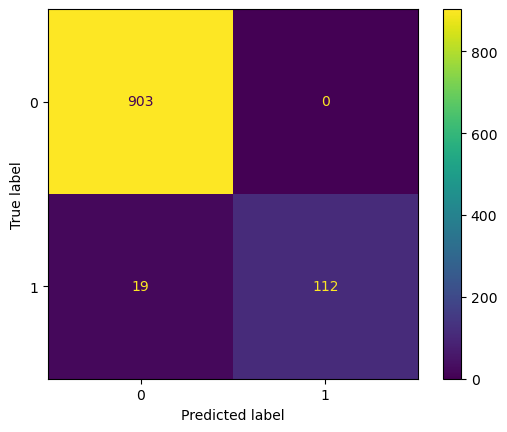

In [63]:
cm = confusion_matrix(y_test, y_pred)
matrix = ConfusionMatrixDisplay(cm, display_labels = best_model.classes_)
matrix.plot()

#### classification report

In [30]:
cr = classification_report(y_test, y_pred, output_dict = True)

Text(0.5, 1.0, 'Classification Report Heatmap')

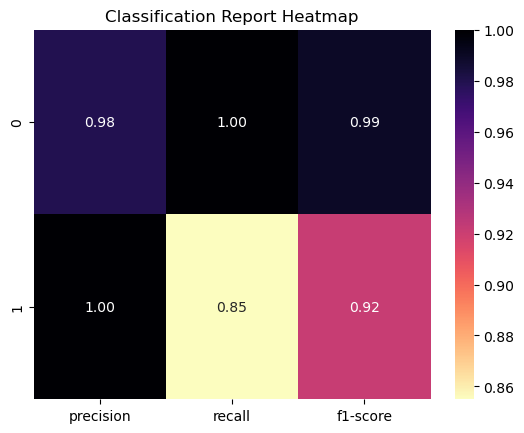

In [64]:
# to get a clearer picture
cr = classification_report(y_test, y_pred, output_dict = True)
cr_df = pd.DataFrame(cr).transpose()
sns.heatmap(cr_df.iloc[:-3, :].drop("support", axis = 1), annot = True, fmt = ".2f", cmap = "magma_r")
plt.title("Classification Report Heatmap")

In [45]:
import streamlit as st
import joblib

In [27]:
joblib.dump(best_model, "best_pipeline.pkl")

['best_pipeline.pkl']

In [28]:
import json

In [32]:
with open("model_metrics.json", "w") as f:
    json.dump(cr, f)